# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.

# Laboratory 7 - Medical Image Registration

The goal of Laboratory 7 is to:
<ol>
  <li> Get familiar with the nonrigid medical image registration.
  <li> Process 3-D volumetric data.
  <li> Learn how to modify a segmentation architecture to a registration architecture.
  <li> Learn how to evaluate the medical image registration.
  <li> Develop a tool to automatically register 3-D MR images of hippocampus.
</ol>

### Introduction

The open dataset comes from: https://learn2reg.grand-challenge.org/Datasets/ and will be provided for you to avoid the grand-challenge registration.

The goal is to register magnetic responance images containing hippocampus from various subjects. It may be useful to e.g. create anatomical atlas and to perform further research about the relation of its shape to a particular disease.

During this laboratory you will use 3-D (low resolution) images. Start with transfering the dataset to your Google Drive and then to Google Colaboratory. Then mount the Google Drive (as during previous laboratories) and follow the notebook.


## Part I - Dataset and Dataloader

In this part you are going to implement Dataset dedicated to the provided data. During the laboratory we are not interested in the real test data. You will create your own training/validation/testing split. The images are in the **imagesTr** folder, and the corresponding ground-truth is in the **labelsTr** folder.

Start with importing the external libraries:

In [1]:
import os
import json
import random
import math
import numpy as np
import torch as tc
import torch.nn.functional as F
import torchvision as tv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import itertools
!pip install SimpleITK
import SimpleITK as sitk # During this laboratory you will need SimpleITK to load 3-D data.
from PIL import Image as im
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
# ! pip install torchsummary
# from torchsummary import summary
! pip install torchsummaryX
from torchsummaryX import summary

2024-06-09 09:30:23.526611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 09:30:23.526747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 09:30:23.658817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
! wget "https://cloud.imi.uni-luebeck.de/s/gPN6bzJ4xf7HzG8/download/HippocampusMR.zip" --directory-prefix "/kaggle/working/"

--2024-06-09 09:30:45--  https://cloud.imi.uni-luebeck.de/s/gPN6bzJ4xf7HzG8/download/HippocampusMR.zip
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56436269 (54M) [application/zip]
Saving to: '/kaggle/working/HippocampusMR.zip'

HippocampusMR.zip   100%[===================>]  53.82M  19.2MB/s    in 2.8s    

2024-06-09 09:30:49 (19.2 MB/s) - '/kaggle/working/HippocampusMR.zip' saved [56436269/56436269]



First, create a .csv file containing relative paths to the image and the corresponding ground-truth. Then split the .csv file into three .csv files related to: training, validation, and testing with ratio 7:1:2. The .csv files should contain columns: "Image_Path", "Label_Path".

In [4]:
from sklearn.model_selection import train_test_split
input_file = "/kaggle/working/HippocampusMR.zip" # Path to the zip file
output_folder = "/kaggle/working/" # Path to the folder where you would like to unzip the input ".zip" file

!unzip $input_file -d $output_folder

dataset_path = "HippocampusMR"
imgs_path = "imagesTr"
lbls_path = "labelsTr"


dataset_csv_path = os.path.join(dataset_path, "dataset.csv")
training_csv_path = os.path.join(dataset_path, "dataset_training.csv")
validation_csv_path = os.path.join(dataset_path, "dataset_validation.csv")
testing_csv_path = os.path.join(dataset_path, "dataset_testing.csv")

# dataset
dataframe = pd.DataFrame()

imgs = os.listdir(os.path.join(dataset_path, imgs_path))
lbls = os.listdir(os.path.join(dataset_path, lbls_path))
image_paths = [os.path.join(imgs_path, path) for path in imgs]
label_paths = [os.path.join(lbls_path, path) for path in lbls]

dataframe['Image_path'] = image_paths
dataframe['Label_path'] = label_paths

# training, validation, testing
split_ratio = (0.7, 0.1, 0.2)

training_dataframe = pd.DataFrame()
validation_dataframe = pd.DataFrame()
testing_dataframe = pd.DataFrame()

train, testing_dataframe = train_test_split(dataframe, test_size=split_ratio[2], random_state=42)
_new_valid_ratio = split_ratio[1] / (split_ratio[0] + split_ratio[1])
_new_valid_ratio = round(_new_valid_ratio, 10)
training_dataframe, validation_dataframe = train_test_split(train, test_size=_new_valid_ratio, random_state=42)


print(f"Number of cases: {len(dataframe)}")
print(f"Number of training cases: {len(training_dataframe)}")
print(f"Number of validation cases: {len(validation_dataframe)}")
print(f"Number of testing cases: {len(testing_dataframe)}")

dataframe.to_csv(dataset_csv_path, index=False)
training_dataframe.to_csv(training_csv_path, index=False)
validation_dataframe.to_csv(validation_csv_path, index=False)
testing_dataframe.to_csv(testing_csv_path, index=False)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /kaggle/working/HippocampusMR.zip
   creating: /kaggle/working/HippocampusMR/
   creating: /kaggle/working/HippocampusMR/imagesTr/
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0037_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0001_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0036_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0002_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0038_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0003_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0039_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0004_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0040_0000.nii.gz  
  inflating: /kaggle/working/HippocampusMR/imagesTr/HippocampusMR_0005_0000.nii.gz  
  inflati

In original notebook version there are 25 validation and 53 testing cases which may cause slight difference but the methods are correct which is validated later

We are interesed in registering the images in the "all-vs-all" scenario. It means that each image within a given set is going to be registered to all the remaining images. Therefore, process the all the .csv files further, to create .csv files with the following columns: "Source_Path", "Target_Path", "Source_Label_Path", "Target_Label_Path". The source is the image that will be registered to the target image. We are adding this two step procedure to avoid any validation bias by including the same case both in training and the validation set. Therefore, in the first step the volumes are splited patient-wise and then further processed to create the registration pairs.

In [5]:
def create_pairs(dataframe):
    processed_dataframe = None
    pairs = list(itertools.product(dataframe.index, repeat=2))

    pairs_df = pd.DataFrame(pairs, columns=['Source', 'Target'])

    # Map the indices to the actual paths
    pairs_df['Source_Path'] = pairs_df['Source'].apply(lambda idx: dataframe.loc[idx, 'Image_path'])
    pairs_df['Source_Label_Path'] = pairs_df['Source'].apply(lambda idx: dataframe.loc[idx, 'Label_path'])
    pairs_df['Target_Path'] = pairs_df['Target'].apply(lambda idx: dataframe.loc[idx, 'Image_path'])
    pairs_df['Target_Label_Path'] = pairs_df['Target'].apply(lambda idx: dataframe.loc[idx, 'Label_path'])

    pairs_df = pairs_df.drop(columns=['Source', 'Target'])

    return pairs_df

processed_training_dataframe = create_pairs(training_dataframe)
processed_validation_dataframe = create_pairs(validation_dataframe)
processed_testing_dataframe = create_pairs(testing_dataframe)

print(f"Number of training pairs: {len(processed_training_dataframe)}")
print(f"Number of validation pairs: {len(processed_validation_dataframe)}")
print(f"Number of testing pairs: {len(processed_testing_dataframe)}")

processed_training_csv_path = os.path.join(dataset_path, "processed_dataset_training.csv")
processed_validation_csv_path = os.path.join(dataset_path, "processed_dataset_validation.csv")
processed_testing_csv_path = os.path.join(dataset_path, "processed_dataset_testing.csv")

processed_training_dataframe.to_csv(processed_training_csv_path, index=False)
processed_validation_dataframe.to_csv(processed_validation_csv_path, index=False)
processed_testing_dataframe.to_csv(processed_testing_csv_path, index=False)

Number of training pairs: 33124
Number of validation pairs: 676
Number of testing pairs: 2704


In [6]:
print(f"correct training amount: {len(training_dataframe)**2}")
print(f"correct validation amount: {len(validation_dataframe)**2}")
print(f"correct testing amount: {len(testing_dataframe)**2}")

correct training amount: 33124
correct validation amount: 676
correct testing amount: 2704


In [7]:
len(testing_dataframe), len(validation_dataframe), len(training_dataframe)

(52, 26, 182)

In [8]:
tmp = 0
for i in range(len(testing_dataframe)+1):
    tmp+=i
print(tmp*2)

tmp = 0
for i in range(len(validation_dataframe)-1):
    tmp+=i
print(tmp*2)

tmp = 0
for i in range(len(training_dataframe)):
    tmp+=i
print(tmp*2)

2756
600
32942


+1 and -1 are for the difference between the method of getting the dataset split (results are correct then, however with mine they are slightly different but the method is correct).

In [9]:
tmp = 0
for i in range(53):
    tmp+=i
print(tmp*2)

tmp = 0
for i in range(25):
    tmp+=i
print(tmp*2)

tmp = 0
for i in range(182):
    tmp+=i
print(tmp*2)

2756
600
32942


The next step is to implement a dedicated Dataset. During each call to the __getitem__ function, the Dataset object should return two 3-D volumes of the hippocampus, and the corresponding segmentation masks (see the class skeleton below). All the outputs should have the shape: (1x64x64x64).

In [10]:
len(processed_validation_dataframe), len(processed_training_dataframe), len(processed_testing_dataframe)

(676, 33124, 2704)

In [11]:
class MRRegistrationDataset(tc.utils.data.Dataset):
    def __init__(self, images_path, labels_path, csv_path, dataset_path):
        # images_path and labels_path are not actually needed because the paths are stored in the .csv file
        self.df = pd.read_csv(csv_path)
        self.dataset_path = dataset_path

    def __len__(self):
        return len(self.df)

    def load_case(self, image_path: str, label_path: str) -> np.array:
        img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dataset_path, image_path)))
        lbl = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dataset_path, label_path)))
        return tc.from_numpy(img).unsqueeze(0), tc.from_numpy(lbl).unsqueeze(0)

    def __getitem__(self, idx):
        current_case = self.df.iloc[idx]
        source, source_mask = self.load_case(current_case['Source_Path'], current_case['Source_Label_Path'])
        target, target_mask = self.load_case(current_case['Target_Path'], current_case['Target_Label_Path'])

        min_source, max_source = tc.min(source), tc.max(source)
        source = ((source - min_source) / (max_source - min_source))

        min_target, max_target = tc.min(source), tc.max(source)
        target = ((target - min_target) / (max_target - min_target))

        # For simplicity, we will evaluate both the structures as whole
        # so mask the mask so all values above 0 are 1
        source_mask[source_mask > 0] = 1
        target_mask[target_mask > 0] = 1

        return source, target, source_mask, target_mask # Note, you will use the masks only during the evaluation

Now verify whether the Dataset is implemented correctly by creating the dataloader and visualizing the loaded MR volume together with the corresponding ground-truth. For now show only the last dimension (middle slice).

Dataset size: 2704
Batch shape: torch.Size([2, 1, 64, 64, 64])
Sources min/max: (tensor(0.), tensor(1.))
Targets min/max: (tensor(0.), tensor(3099.3040))
Sources_masks min/max: (tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8))
Targets_masks min/max: (tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8))


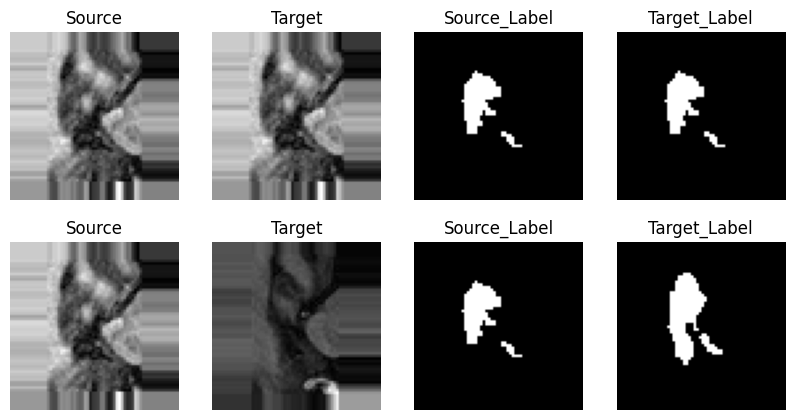

In [12]:
images_path = os.path.join(dataset_path, "imagesTr")
labels_path = os.path.join(dataset_path, "labelsTr")
testing_dataset = MRRegistrationDataset(images_path, labels_path, processed_testing_csv_path, dataset_path)

batch_size = 2
print(f"Dataset size: {len(testing_dataset)}")
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

for sources, targets, sources_masks, targets_masks in testing_dataloader:
    rows = batch_size
    cols = 4
    print(f"Batch shape: {sources.size()}")
    print(f"Sources min/max: {sources.min(), sources.max()}")
    print(f"Targets min/max: {targets.min(), targets.max()}")
    print(f"Sources_masks min/max: {sources_masks.min(), sources_masks.max()}")
    print(f"Targets_masks min/max: {targets_masks.min(), targets_masks.max()}")

    # pass # TODO - prepare visualization as below
    fig, ax = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
    for i in range(rows):
        ax[i, 0].imshow(sources[i, 0, 32, :, :].detach().cpu().numpy(), cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_title('Source')
        ax[i, 1].imshow(targets[i, 0, 32, :, :].detach().cpu().numpy(), cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_title('Target')
        ax[i, 2].imshow(sources_masks[i, 0, 32, :, :].detach().cpu().numpy(), cmap='gray')
        ax[i, 2].axis('off')
        ax[i, 2].set_title('Source_Label')
        ax[i, 3].imshow(targets_masks[i, 0, 32, :, :].detach().cpu().numpy(), cmap='gray')
        ax[i, 3].axis('off')
        ax[i, 3].set_title('Target_Label')

    break

## Part II - Registration Architecture

The next step is to implement the registration architecture. This step will be rather straightforward. You can modify the 2-D UNet architecture from the previous laboratory as follows:

<ol>
  <li> Replace all 2-D operations with 3-D operations.
  <li> Decrease the network depth because the input volumes are 64x64x64, therefore, 4 network levels should be enough.
  <li> Modify the input to contain two channels (the source and target images stacked channel-wise) and the output to contain three channels (3-D displacement field).
  <li> Decreate the number of channels for given layers to 2 -> 16 -> 32 -> 64 -> 64 (to speed-up the training, in fact, the number of layers could be higher).
  <li> Remove the Sigmoid activation.
</ol>

In [13]:
# ------------------------------------------------------------------------------------- ENCODER
class Encoder(tc.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        input_channels      = [ 2, 16, 32,  64]
        output_channels     = [16, 32, 64, 128] # 128 so that we can smoothly connect skips

        kernel_sizes        = [3, 3, 3, 3]
        strides             = [1, 1, 1, 1]
        paddings            = [1, 1, 1, 1]

        self.enc_layers = tc.nn.ModuleList()
        self.pool_layer = tc.nn.ModuleList()
        for idx, (in_ch, out_ch, k_size, stride, pad) in enumerate(zip(input_channels, output_channels,
                                                                kernel_sizes, strides, paddings)):
            self.enc_layers.append(tc.nn.Sequential(
                tc.nn.Conv3d(in_ch, out_ch, kernel_size=k_size, stride=stride, padding=pad),
                tc.nn.BatchNorm3d(out_ch),
                tc.nn.ReLU(),
                tc.nn.Conv3d(out_ch, out_ch, kernel_size=k_size, stride=stride, padding=pad),
                tc.nn.BatchNorm3d(out_ch),
                tc.nn.ReLU()
            ))
            if idx < len(input_channels) - 1:
                self.pool_layer.append(tc.nn.MaxPool3d(kernel_size=2))

    def forward(self, x):
        skips = []
        for i in range(len(self.enc_layers)):
            x = self.enc_layers[i](x)

            if i < len(self.enc_layers) - 1:
                skips.append(x)
                x = self.pool_layer[i](x)
        return x, skips

# ------------------------------------------------------------------------------------- DECODER
class Decoder(tc.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        input_channels      = [128, 128, 64, 32]
        output_channels     = [128,  64, 32, 16]

        kernel_sizes        = [3, 3, 3, 3]
        strides             = [1, 1, 1, 1]
        paddings            = [1, 1, 1, 1]

        upconv_size         = [2, 2, 2]
        upconv_strides      = [2, 2, 2]
        upconv_paddings     = [0, 0, 0]
        out_seg_channels    = 3

        self.upconvs = tc.nn.ModuleList()
        for idx, (in_ch, out_ch) in enumerate(zip(input_channels[1:], output_channels[1:])):
            self.upconvs.append(tc.nn.ConvTranspose3d(in_ch, in_ch // 2,
                                                      kernel_size=upconv_size[idx],
                                                      padding=upconv_paddings[idx],
                                                      stride=upconv_strides[idx]
                                                      ).to(device)
            )

        self.dec_layers = tc.nn.ModuleList()
        for idx, (in_ch, out_ch, k_size, stride, pad) in enumerate(zip(input_channels, output_channels, kernel_sizes, strides, paddings)): # [96, 48, 24, 12]
            self.dec_layers.append(tc.nn.Sequential(
                tc.nn.Conv3d(in_ch, out_ch, kernel_size=k_size, stride=stride, padding=pad),
                tc.nn.BatchNorm3d(out_ch),
                tc.nn.ReLU(),
                tc.nn.Conv3d(out_ch, out_ch, kernel_size=k_size, stride=stride, padding=pad),
                tc.nn.BatchNorm3d(out_ch),
                tc.nn.ReLU()
            ).to(device))

        self.out = tc.nn.Conv3d(output_channels[-1], out_seg_channels, kernel_size=1, stride=1, padding=0).to(device)

    def forward(self, x, skips):
        for i in range(len(self.dec_layers)):
            if i!=0:
                x = self.upconvs[i-1](x)
                skip = skips[-(i)]
                x = tc.cat((x, skip), dim=1)
            x = self.dec_layers[i](x)
        x = self.out(x)
        return x

# ------------------------------------------------------------------------------------- REGUNET
class RegUNet(tc.nn.Module):
    def __init__(self):
        super(RegUNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.decoder(x, skips)
        return x.moveaxis(1, -1)


Now verify whether the images are propagated correctly:

Sources shape: torch.Size([2, 1, 64, 64, 64])
Targets shape: torch.Size([2, 1, 64, 64, 64])
Output shape: torch.Size([2, 3, 64, 64, 64])


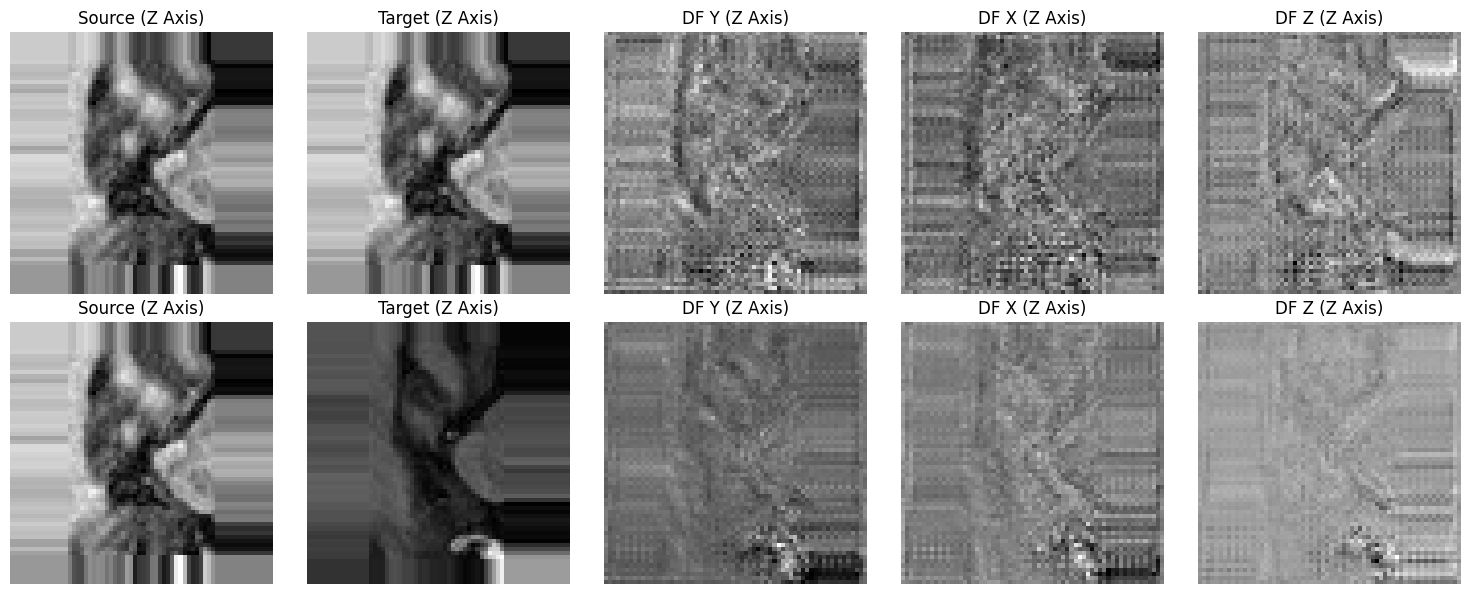

In [14]:
device = tc.device('cuda:0' if tc.cuda.is_available() else 'cpu')
model = RegUNet().to(device)

# Loop through the testing dataloader
for sources, targets, sources_masks, targets_masks in testing_dataloader:
    displacement_fields = model(tc.cat((sources, targets), dim=1).to(device)).cpu().detach()

    rows = sources.shape[0]
    cols = 5  # Source, Target, DF Y, DF X, DF Z

    print(f"Sources shape: {sources.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Output shape: {displacement_fields.moveaxis(-1, 1).shape}")

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    for i in range(rows):
        # Source and Target images
        source_img = sources[i, 0, :, :, :].cpu().numpy()  # Assume source and target are single channel
        target_img = targets[i, 0, :, :, :].cpu().numpy()

        # Displacement fields
        df_y = displacement_fields.moveaxis(-1, 1)[i, 0, :, :, :].detach().cpu().numpy()
        df_x = displacement_fields.moveaxis(-1, 1)[i, 1, :, :, :].detach().cpu().numpy()
        df_z = displacement_fields.moveaxis(-1, 1)[i, 2, :, :, :].detach().cpu().numpy()

        # Plot the middle slice along the Z-axis
        mid_slice = source_img.shape[0] // 2

        axes[i, 0].imshow(source_img[mid_slice, :, :], cmap='gray')
        axes[i, 0].set_title("Source (Z Axis)")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(target_img[mid_slice, :, :], cmap='gray')
        axes[i, 1].set_title("Target (Z Axis)")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(df_y[mid_slice, :, :], cmap='gray')
        axes[i, 2].set_title("DF Y (Z Axis)")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(df_x[mid_slice, :, :], cmap='gray')
        axes[i, 3].set_title("DF X (Z Axis)")
        axes[i, 3].axis('off')

        axes[i, 4].imshow(df_z[mid_slice, :, :], cmap='gray')
        axes[i, 4].set_title("DF Z (Z Axis)")
        axes[i, 4].axis('off')

    plt.tight_layout()
    plt.show()
    break

# The model is not trained yet, therefore the output displacement field is just a noise.

## Part III - Neural Network Training

Now it is the time to train the neural network. In contrast to the training from previous laboratories, we are not going to use the supervised learning. The network will be trained in a fully unsupervised way, without using any ground-truth directly during training (even though for this problem it is possible - the training labels are available and could be utilized).

The objective function for unsupervised, nonrigid medical image registration usually consists two terms: (i) the dissmilarity term, (ii) the regularization function.

The dissimilarity term is responsible for evaluating how disimilar the input images are. We would like to minimize this quantitity to make the images as similar as possible. During this laboratory you are going to use local normalized cross-correlation (local NCC). The source code is provided for you below.

The regularization term is necessary because without any constraints the network would learn a "perfect mapping" (there is more than one unique solution to the problem) ignoring the fact that the neighbouring voxels in the input volume, should still be close to each other after the spatial transformation. Therefore, it is beneficial to penalize large disagreements between neighbouring displacement vectors. During this laboratory you are going to use the diffusive regularization. The source code is provided for you below.

The final objective function is a weighted sum of the dissimilarity term and the regularization term. The regularization coefficient (constant multiplied by the result of the regularization function) controls the transformation smoothness.

In [15]:
def generate_grid(tensor_size: tc.Tensor, device="cpu"):
    """
    Utility function to generate an identity transform.
    """
    identity_transform = tc.eye(len(tensor_size)-1, device=device)[:-1, :].unsqueeze(0)
    identity_transform = tc.repeat_interleave(identity_transform, tensor_size[0], dim=0)
    grid = F.affine_grid(identity_transform, tensor_size, align_corners=False)
    return grid

def warp_tensor(tensor: tc.Tensor, displacement_field: tc.Tensor, grid: tc.Tensor=None, device: str="cpu", mode: str='bilinear'):
    """
    Utility function to warp the tensors.
    """
    if grid is None:
        grid = generate_grid(tensor.size(), device=device)
    sampling_grid = grid + displacement_field
    transformed_tensor = F.grid_sample(tensor, sampling_grid, mode=mode, padding_mode='zeros', align_corners=False)
    return transformed_tensor

def ncc_local_tc(sources: tc.Tensor, targets: tc.Tensor, device: str="cpu", **params):
    """
    Local normalized cross correlation.
    """
    ndim = len(sources.size()) - 2
    if ndim not in [2, 3]:
        raise ValueError("Unsupported number of dimensions.")
    try:
        win_size = params['win_size']
    except:
        win_size = 3
    window = (win_size, ) * ndim
    sum_filt = tc.ones([1, 1, *window]).to(device)
    pad_no = math.floor(window[0] / 2)
    stride = ndim * (1,)
    padding = ndim * (pad_no,)
    conv_fn = getattr(F, 'conv%dd' % ndim)
    sources_denom = sources**2
    targets_denom = targets**2
    numerator = sources*targets
    sources_sum = conv_fn(sources, sum_filt, stride=stride, padding=padding)
    targets_sum = conv_fn(targets, sum_filt, stride=stride, padding=padding)
    sources_denom_sum = conv_fn(sources_denom, sum_filt, stride=stride, padding=padding)
    targets_denom_sum = conv_fn(targets_denom, sum_filt, stride=stride, padding=padding)
    numerator_sum = conv_fn(numerator, sum_filt, stride=stride, padding=padding)
    size = np.prod(window)
    u_sources = sources_sum / size
    u_targets = targets_sum / size
    cross = numerator_sum - u_targets * sources_sum - u_sources * targets_sum + u_sources * u_targets * size
    sources_var = sources_denom_sum - 2 * u_sources * sources_sum + u_sources * u_sources * size
    targets_var = targets_denom_sum - 2 * u_targets * targets_sum + u_targets * u_targets * size
    ncc = cross * cross / (sources_var * targets_var + 1e-5)
    return -tc.mean(ncc)

def diffusion_tc(displacement_field: tc.Tensor, device: str="cpu", **params):
    """
    Diffusive regularization.
    """
    ndim = len(displacement_field.size()) - 2
    if ndim == 3:
        dx = (displacement_field[:, 1:, :, :, :] - displacement_field[:, :-1, :, :, :])**2
        dy = (displacement_field[:, :, 1:, :, :] - displacement_field[:, :, :-1, :, :])**2
        dz = (displacement_field[:, :, :, 1:, :] - displacement_field[:, :, :, :-1, :])**2
        diffusion_reg = (tc.mean(dx) + tc.mean(dy) + tc.mean(dz)) / 3
    else:
        raise ValueError("Unsupported number of dimensions.")
    return diffusion_reg

Start with implementing the training function:

In [16]:
def training(model, training_dataloader, validation_dataloader,
             disimilarity_function, regularization_function, regularization_coefficient,
             optimizer, num_epochs, logger, device):
    
    print("Started training")
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Started epoch {epoch}: ")
        model.train()
        train_loss = 0.0

        for batch_idx, (sources, targets, sources_masks, targets_masks) in enumerate(training_dataloader): #tqdm(enumerate(training_dataloader), 
#                                                                                 desc=f"Epoch {epoch+1} train", 
#                                                                                 total=len(training_dataloader)):
            sources, targets = sources.to(device), targets.to(tc.float32).to(device)
            optimizer.zero_grad()

            displacement_fields = model(tc.cat((sources, targets), dim=1))

            # Warp the source images
            grid = generate_grid(sources.size(), device=device)
            warped_sources = warp_tensor(sources, displacement_fields, grid=grid, device=device)

            # Compute the loss
            dissimilarity_loss = disimilarity_function(warped_sources, targets, device=device)
            regularization_loss = regularization_function(displacement_fields, device=device)
            loss = dissimilarity_loss + regularization_coefficient * regularization_loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()


        avg_train_loss = train_loss / len(training_dataloader)
        logger.add_scalar('Loss/train', avg_train_loss, epoch)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with tc.no_grad():
            for batch_idx, (sources, targets, sources_masks, targets_masks) in tqdm(enumerate(validation_dataloader),
                                                                                    desc=f"Epoch {epoch+1} val",
                                                                                    total=len(validation_dataloader)):
                sources, targets = sources.to(device), targets.to(tc.float32).to(device)

                displacement_fields = model(tc.cat((sources, targets), dim=1))

                # Warp the source images
                grid = generate_grid(sources.size(), device=device)
                warped_sources = warp_tensor(sources, displacement_fields, grid=grid, device=device)

                # Compute the loss
                dissimilarity_loss = disimilarity_function(warped_sources, targets, device=device)
                regularization_loss = regularization_function(displacement_fields, device=device)
                loss = dissimilarity_loss + regularization_coefficient * regularization_loss

                val_loss += loss.item()


        avg_val_loss = val_loss / len(validation_dataloader)
        logger.add_scalar('Loss/val', avg_val_loss, epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        model_save_dir = r"/kaggle/working/models"
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, f"model_{epoch+1}.pt")
        tc.save(model.state_dict(), model_save_path)
        
    print("Ended training")

Now initialize the model and the training parameters:

In [17]:
learning_rate = 0.003
model = RegUNet().to(device)
batch_size = 16
num_epochs = 10
parameters = model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = "cuda:0" if tc.cuda.is_available() else "cpu"
logger = SummaryWriter(log_dir=os.path.join(dataset_path, "logs"), comment="RegUNet")
disimilarity_function = ncc_local_tc
regularization_function = diffusion_tc
regularization_coefficient = 3500


training_dataset = MRRegistrationDataset(images_path, labels_path, processed_training_csv_path, dataset_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = MRRegistrationDataset(images_path, labels_path, processed_validation_csv_path, dataset_path)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

Now initialize the TensorBoard logger:

*Actually I ran this notebook in kaggle and had to delete the cell with tensorboard due to some problems regarding the running*

And finally run the training:

In [18]:
training(model, training_dataloader, validation_dataloader,
             disimilarity_function, regularization_function, regularization_coefficient,
             optimizer, num_epochs, logger, device)

Started training
Started epoch 0: 


Epoch 1 val: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s]


Epoch 1/10, Train Loss: 35.2659, Val Loss: 11.8261
Started epoch 1: 


Epoch 2 val: 100%|██████████| 43/43 [00:23<00:00,  1.85it/s]


Epoch 2/10, Train Loss: 23.5853, Val Loss: 40.1512
Started epoch 2: 


Epoch 3 val: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s]


Epoch 3/10, Train Loss: 37.6692, Val Loss: 45.6327
Started epoch 3: 


Epoch 4 val: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s]


Epoch 4/10, Train Loss: 37.8080, Val Loss: 134.9904
Started epoch 4: 


Epoch 5 val: 100%|██████████| 43/43 [00:23<00:00,  1.82it/s]


Epoch 5/10, Train Loss: 101.4176, Val Loss: 69.8168
Started epoch 5: 


Epoch 6 val: 100%|██████████| 43/43 [00:23<00:00,  1.81it/s]


Epoch 6/10, Train Loss: 118.3847, Val Loss: 169.2865
Started epoch 6: 


Epoch 7 val: 100%|██████████| 43/43 [00:23<00:00,  1.82it/s]


Epoch 7/10, Train Loss: 117.0302, Val Loss: 138.1945
Started epoch 7: 


Epoch 8 val: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s]


Epoch 8/10, Train Loss: 116.1973, Val Loss: 109.1266
Started epoch 8: 


Epoch 9 val: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s]


Epoch 9/10, Train Loss: 116.2753, Val Loss: 132.8869
Started epoch 9: 


Epoch 10 val: 100%|██████████| 43/43 [00:23<00:00,  1.83it/s]

Epoch 10/10, Train Loss: 115.8599, Val Loss: 231.3522
Ended training


## Part IV - Evaluation and Results Analysis

You are going the evaluate the trained network on all the three datasets. You will evaluate the registration quality using the Dice coefficient and 95th percentile of Hausdorff distance between the transformed source label and the target label. It is also useful to calculate the initial Dice coefficient (before the registration). You will use the same evaluation functions as during the previous laboratory.

Please note that usually it not enough to calculate the Dice coefficient and the Hausdorff distance only. It is common to introduce also the target registration error (TRE) calculated between corresponding points before and after the registration, and also metrics related to the displacement smoothness, e.g. folding ratio (% of voxels with negative Jacobian).

Below are the functions you are going to use for the evaluation (the same as during the segmentation class):

In [19]:
from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure
from glob import glob


def dc(input1, input2):
    input1 = np.atleast_1d(input1)
    input2 = np.atleast_1d(input2)
    intersection = np.count_nonzero(input1 & input2)
    size_i1 = np.count_nonzero(input1)
    size_i2 = np.count_nonzero(input2)
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    result = np.atleast_1d(result)
    reference = np.atleast_1d(reference)
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
    footprint = generate_binary_structure(result.ndim, connectivity)
    if 0 == np.count_nonzero(result):
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == np.count_nonzero(reference):
        raise RuntimeError('The second supplied array does not contain any binary object.')
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    return sds

def hd95(result, reference, voxelspacing=None, connectivity=1):
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity)
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity)
    hd95 = np.percentile(np.hstack((hd1, hd2)), 95)
    return hd95

/tmp/ipykernel_24/3981605412.py:2: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure
/tmp/ipykernel_24/3981605412.py:2: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure
/tmp/ipykernel_24/3981605412.py:2: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure


Now accumulate the metrics for all three datasets:

In [20]:
batch_size = 16
training_dataset = MRRegistrationDataset(images_path, labels_path, processed_training_csv_path, dataset_path)
validation_dataset = MRRegistrationDataset(images_path, labels_path, processed_validation_csv_path, dataset_path)
testing_dataset = MRRegistrationDataset(images_path, labels_path, processed_testing_csv_path, dataset_path)

training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

def accumulate_metrics(model, dataloader, device):
    initial_dices = []
    registered_dices = []
    initial_hds95 = []
    registered_hds95 = []

    model.eval()
#     iteration = 0
    with tc.no_grad():
        for sources, targets, sources_masks, targets_masks in tqdm(dataloader, desc="Evaluating"):
            sources, targets = sources.to(device), targets.to(device)
            displacement_fields = model(tc.cat((sources, targets), dim=1))
            
            grid = generate_grid(sources.size(), device=device)
            warped_sources = warp_tensor(sources, displacement_fields, grid=grid, device=device)

            warped_sources = warped_sources.cpu().numpy()
            targets = targets.cpu().numpy()
            sources_masks = sources_masks.cpu().numpy()
            targets_masks = targets_masks.cpu().numpy()

            for warped_source, target, source_mask, target_mask in zip(warped_sources, targets, sources_masks, targets_masks):
                initial_dices.append(dc(source_mask.astype(bool), target_mask.astype(bool)))
                registered_dices.append(dc(warped_source.astype(bool), target.astype(bool)))
                initial_hds95.append(hd95(source_mask.astype(bool), target_mask.astype(bool)))
                registered_hds95.append(hd95(warped_source.astype(bool), target.astype(bool)))
            
#             if iteration == 10:
#                 break
#             iteration+=1

    return (initial_dices, registered_dices, initial_hds95, registered_hds95)

tr_initial_dices, tr_registered_dices, tr_initial_hds95, tr_registered_hds95 = accumulate_metrics(model, training_dataloader, device)
val_initial_dices, val_registered_dices, val_initial_hds95, val_registered_hds95 = accumulate_metrics(model, validation_dataloader, device)
ts_initial_dices, ts_registered_dices, ts_initial_hds95, ts_registered_hds95 = accumulate_metrics(model, testing_dataloader, device)


Evaluating: 100%|██████████| 169/169 [10:03<00:00,  3.57s/it]


Plot the distribution of errors before and after the registration:

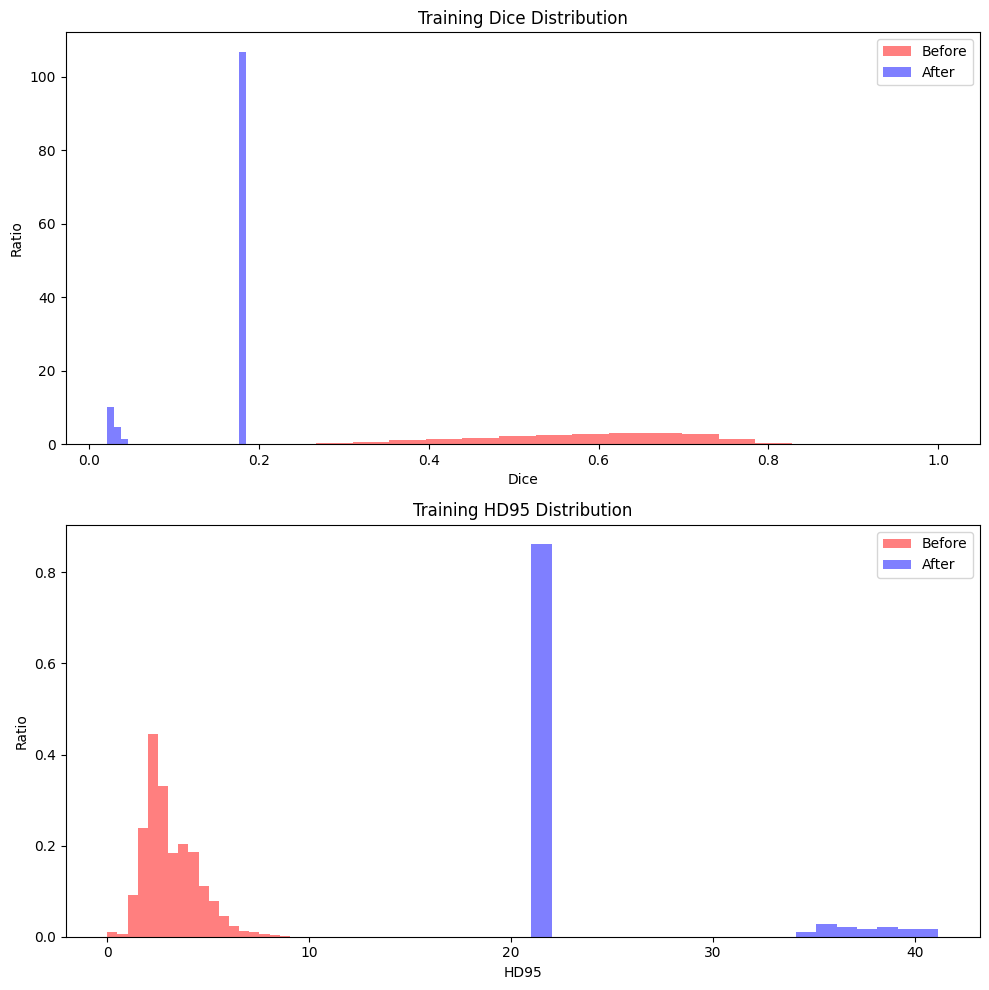

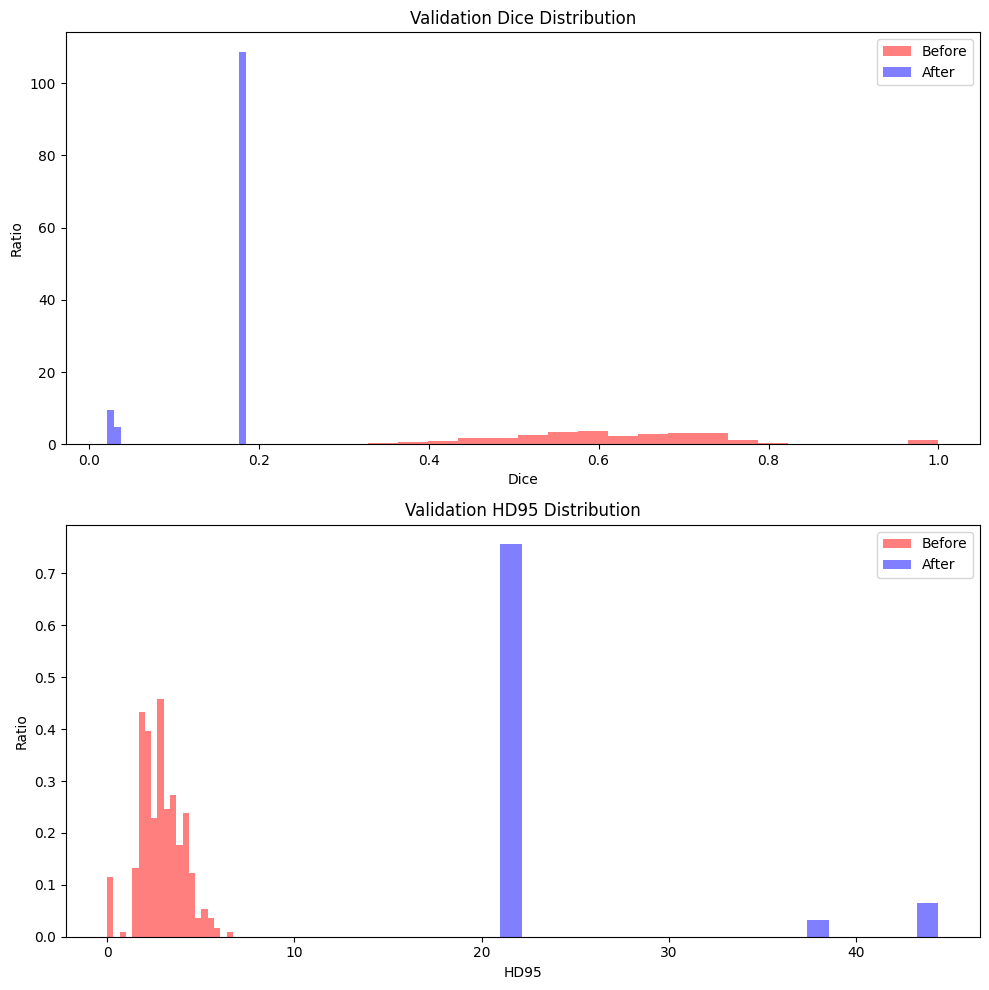

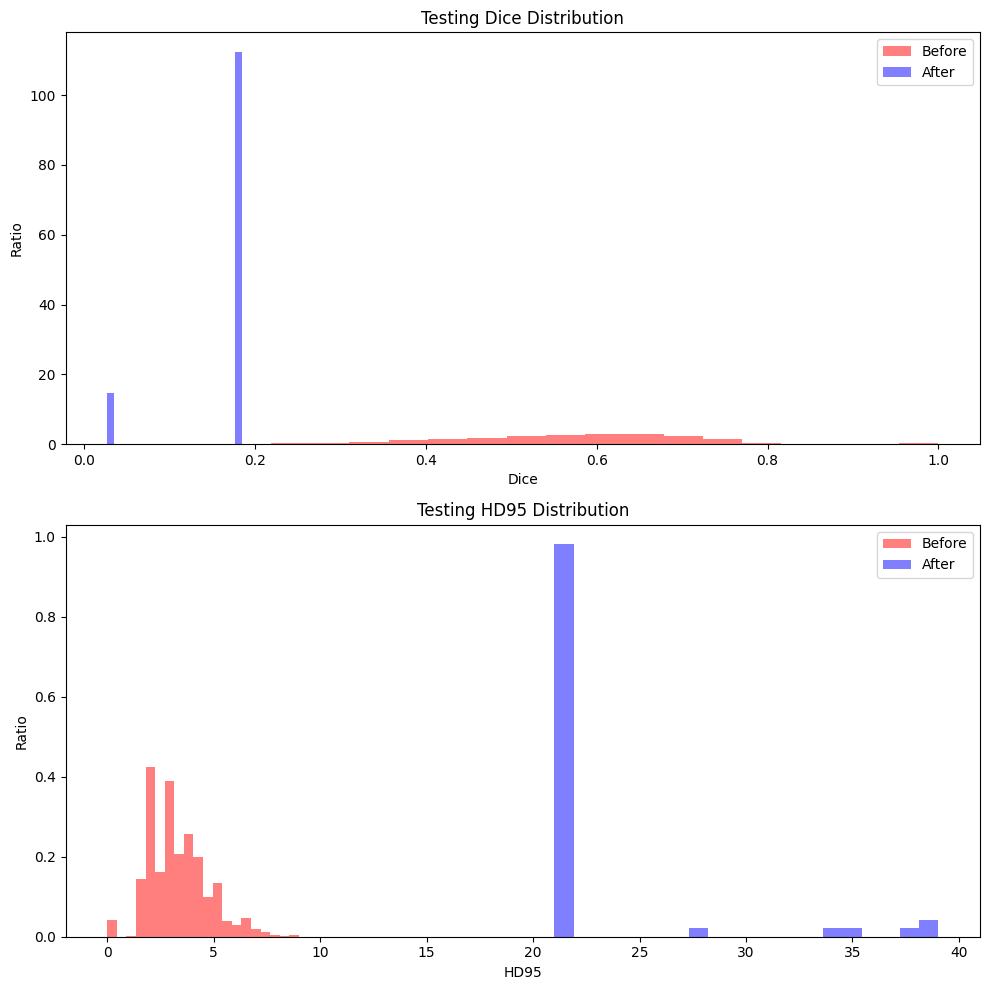

In [21]:
import matplotlib.pyplot as plt

def plot_metric_distributions(initial_dices, registered_dices, initial_hds95, registered_hds95, phase):
    plt.figure(figsize=(10, 10))

    # Dice
    plt.subplot(2, 1, 1)
    plt.hist(initial_dices, bins=20, alpha=0.5, label='Before', color='r', density=True)
    plt.hist(registered_dices, bins=20, alpha=0.5, label='After', color='b', density=True)
    plt.title(f'{phase} Dice Distribution')
    plt.xlabel('Dice')
    plt.ylabel('Ratio')
    plt.legend()

    # HD95
    plt.subplot(2, 1, 2)
    plt.hist(initial_hds95, bins=20, alpha=0.5, label='Before', color='r', density=True)
    plt.hist(registered_hds95, bins=20, alpha=0.5, label='After', color='b', density=True)
    plt.title(f'{phase} HD95 Distribution')
    plt.xlabel('HD95')
    plt.ylabel('Ratio')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metric_distributions(tr_initial_dices, tr_registered_dices, tr_initial_hds95, tr_registered_hds95, phase="Training")
plot_metric_distributions(val_initial_dices, val_registered_dices, val_initial_hds95, val_registered_hds95, phase="Validation")
plot_metric_distributions(ts_initial_dices, ts_registered_dices, ts_initial_hds95, ts_registered_hds95, phase="Testing")


Finally, implement a visualization of the results before and after the registration for the training and the testing set:

torch.cuda.FloatTensor
torch.ByteTensor


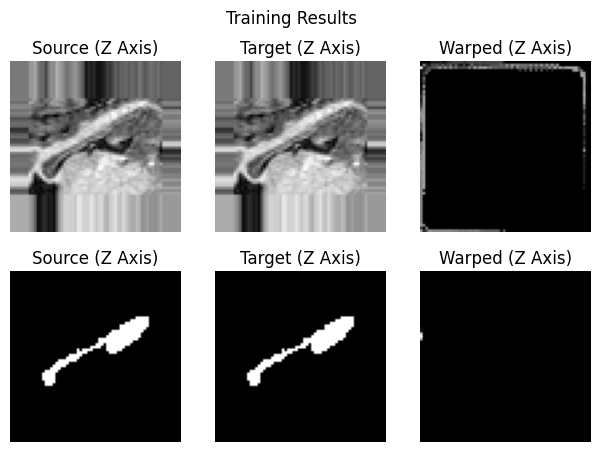

torch.cuda.FloatTensor
torch.ByteTensor


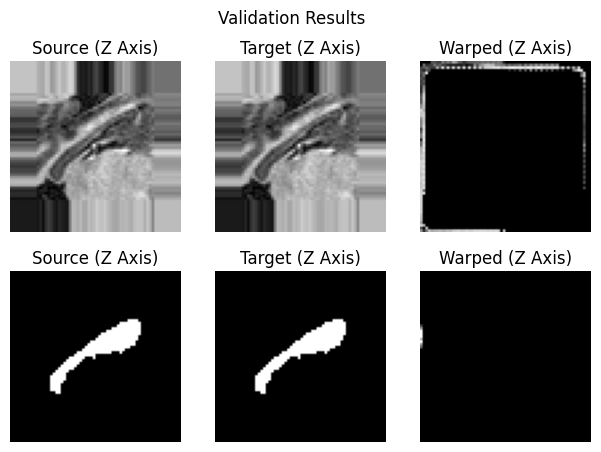

torch.cuda.FloatTensor
torch.ByteTensor


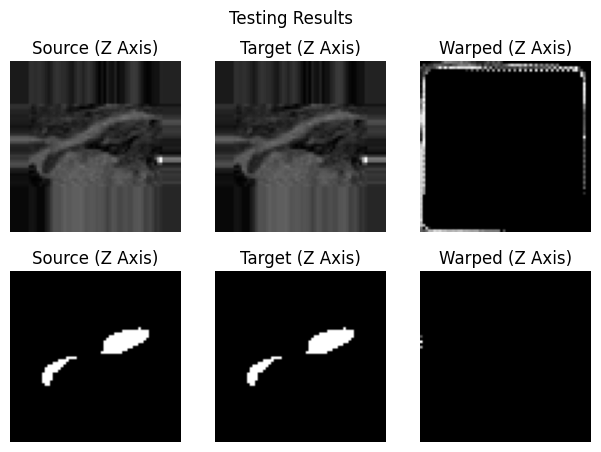

In [22]:
def visualize_registration_results(dataloader, model, device, phase):
    model.eval()
    with tc.no_grad():
        for sources, targets, sources_masks, targets_masks in dataloader:
            sources, targets = sources.to(device), targets.to(tc.float32).to(device)
            displacement_fields = model(tc.cat((sources[0].unsqueeze(0), targets[0].unsqueeze(0)), dim=1))
            grid = generate_grid(sources.size(), device=device)
            warped_sources = warp_tensor(sources, displacement_fields, grid=grid, device=device)
            print(sources.type())
            print(sources_masks.type())
            warped_sources_masks = warp_tensor(sources_masks.to(tc.float32).to(device), displacement_fields, grid=grid, device=device)

            rows = 2
            cols = 3
            
            # Displacement fields
            df_z = displacement_fields.moveaxis(-1, 1)[0, 2, :, :, :].detach().cpu().numpy()
            
            fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
            
            source_img = sources[0, 0, ...].cpu().numpy()
            source_mask = sources_masks[0, 0, ...].cpu().numpy()
            
            target_img = targets[0, 0, ...].cpu().numpy()
            target_mask = targets_masks[0, 0, ...].cpu().numpy()
            
            warped_img = warped_sources[0, 0, ...].cpu().numpy()
            warped_source_mask = warped_sources_masks[0, 0, ...].cpu().numpy()
            
            mid_slice = source_img.shape[-1] // 2
            
            axes[0, 0].imshow(source_img[..., mid_slice], cmap='gray')
            axes[0, 0].set_title("Source (Z Axis)")
            axes[0, 0].axis('off')

            axes[1, 0].imshow(source_mask[..., mid_slice], cmap='gray')
            axes[1, 0].set_title("Source (Z Axis)")
            axes[1, 0].axis('off')

            axes[0, 1].imshow(target_img[..., mid_slice], cmap='gray')
            axes[0, 1].set_title("Target (Z Axis)")
            axes[0, 1].axis('off')

            axes[1, 1].imshow(target_mask[..., mid_slice], cmap='gray')
            axes[1, 1].set_title("Target (Z Axis)")
            axes[1, 1].axis('off')

            axes[0, 2].imshow(warped_img[..., mid_slice], cmap='gray')
            axes[0, 2].set_title("Warped (Z Axis)")
            axes[0, 2].axis('off')
            
            axes[1, 2].imshow(warped_source_mask[..., mid_slice], cmap='gray')
            axes[1, 2].set_title("Warped (Z Axis)")
            axes[1, 2].axis('off')
            
            plt.suptitle(f'{phase} Results')
            plt.show()
            break

visualize_registration_results(training_dataloader, model, device, phase="Training")
visualize_registration_results(validation_dataloader, model, device, phase="Validation")
visualize_registration_results(testing_dataloader, model, device, phase="Testing")

## Conclusion

These results are looking very incorrect. This could be due to problem in architecture, or in training, or both. The evaluations are not actually so obvious to come up with and probably needs more understanding.

Unfortunatelly, the dice coefficient suggests that the results are more similar to each other by them selves, than after my registration (which is understandable). Due to the time of the training (around 40 minutes per epoch on GPU and around 2h on CPU) it is very hard to determine the immediate results and how model  performs.

This is the end of Laboratory 7. You should be now familiar with:
<ol>
  <li> Basics of medical image registration.
  <li> That the objective function can be composed of several cost functions.
  <li> Processing the 3-D volumes.
  <li> The fact that a single deep architecture can be used for various tasks.
</ol>

Note that during this laboratory you implemented the unsupervised training. However, since the segmentation masks were available, you could utilize them during training to further improve the results by adding a third term to the objective function, e.g. the soft Dice score between the warped segmentation mask and the target segmentation mask. Such an approach is called semi-supervised learning because the supervised labels are used only to improve the results, yet it is still possibe to train a given algorithm without them.

The next lecture / laboratory will discuss the generative networks. You are going to implement three neural network architectures to generate synthetic medical images (AE, VAE, GAN).